# This notebook shows the optimization to find the best spectral bands for unmixing a set of endmember spectra from a hyperspectral cube.

In [1]:
%pylab inline
from pysptools import abundance_maps
import random
import pandas as pd
import urllib
import itertools
from scipy.io import loadmat
from scipy.signal import convolve2d

Populating the interactive namespace from numpy and matplotlib


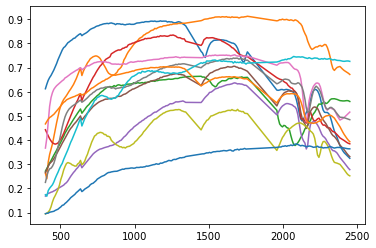

In [2]:
dataset = "cuprite"

d = loadmat("../input/reference-datasets/" + dataset + "/" + dataset + ".mat")
em = loadmat("../input/reference-datasets/" + dataset + "/endmembers/endmembers.mat")
dinfo = pd.read_csv("../input/reference-datasets/" + dataset + "/info.csv",header=None,index_col=None,names=["parameter",'value','unit'])

nrow = int(dinfo[dinfo['parameter'] == 'nrow'].value.values[0])
ncol = int(dinfo[dinfo['parameter'] == 'ncol'].value.values[0])

nbands = int(dinfo[dinfo['parameter'] == 'nbands'].value.values[0])
spec_start = dinfo[dinfo['parameter'] == 'spec_start'].value.values[0]
spec_end = dinfo[dinfo['parameter'] == 'spec_end'].value.values[0]

data = d['Y']
data = data / data.max()
try:
    spec_bands = d['SlectBands'].flatten()
except:
    spec_bands = arange(0,nbands)

# Define wavelength array
wavelength = linspace(spec_start,spec_end,nbands)
wavelength = wavelength[spec_bands]

if len(em['M']) > len(wavelength):
    endmembers = em['M'][spec_bands]
else:
    endmembers = em['M']

endmembers = endmembers.reshape(len(wavelength),-1)

a_map = em["A"].reshape((endmembers.shape[1],nrow,ncol)).T

hypercube = data.copy()
spectra = endmembers.T
hypercube = hypercube.reshape(len(wavelength), a_map.shape[1], a_map.shape[0]).T

figure(1)
plot(wavelength, spectra[0])
plot(wavelength, spectra[1])
plot(wavelength, spectra[2])
plot(wavelength, spectra[3])
plot(wavelength, spectra[4])
plot(wavelength, spectra[5])
plot(wavelength, spectra[6])
plot(wavelength, spectra[7])
plot(wavelength, spectra[8])
plot(wavelength, spectra[9])
plot(wavelength, spectra[10])
plot(wavelength, spectra[11])
plt.show()

'cut it first, my computer cannot run the whole dataset, need to used online GPU'

# upper left corner
area_1 = hypercube[:20,:20,:]
map_1 = a_map[:20,:20,:]

#centre
area_2 = hypercube[100:120,100:120,:]
map_2 = a_map[:20,:20,:]

#endmember 6
area_3 = hypercube[100:120,130:150,:]
map_3 = a_map[100:120,130:150,:]

#endmember 7
area_4 = hypercube[230:250,100:120,:]
map_4 = a_map[230:250,100:120,:]


data_1 = np.append(area_1, area_2,axis = 0)
data_map_1 = np.append(map_1, map_2, axis = 0)

data_2 = np.append(area_3, area_4,axis = 0)
data_map_2 = np.append(map_3, map_4, axis = 0)

hypercube = np.append(data_1, data_2,axis = 1)
a_map = np.append(data_map_1, data_map_2,axis = 1)



In [3]:
def create_hypercube(a_map, spectra):
 
    '''
    Generate a hypercube.
    
    Inputs:
        a_map (N*M, L)
             
        spectra (L x Q array) - Array of 1D spectral respones for each pixel. Number of array members
            should be equal to the maximum value in im (L). Q is sample points in wavelength space.        
    
    N represents N*M!
    
    Output:
        hypercube (N*M, Q)
    '''

    N,_ = a_map.shape
    L,Q = spectra.shape

    hypercube = zeros((N,Q))
    
    for i in range(L):
        hypercube += outer(a_map[:,i],spectra[i]).reshape((N,Q))
    
    return hypercube

In [4]:
def pre_processing(hypercube, abundance_map, endmembers, wavelength, center_wavelengths, bandwidths, return_predicted=False):
    '''
    Function to compute unmixing accuracy using NNLS spectral unmixing given a set of spectral band 
    center wavelengths and bandwidths. Assuming gaussian filter responses with a bandwidth defined
    as the FWHM.
    
    Inputs:
        hypercube (N X M x Q) - 3D synthetic hypercube.
        
        abundance_map (N x M x P)- 3D ground-truth abundance map of target. Each channel in L corresponds to the
             abundance (between 0 and 1) of the spectral signature in the spectra array. 
        
        endmembers (P x Q array) - Array of endmember signals to unmix.
        
        wavelength (1 x Q array) - Array describing the wavelength value corresponding to the spectral
            response arrays.
        
        center_wavelengths (1 x L array) - Array or list of center wavelengths for Gaussian filter responses
            to use for unmixing.
        
        bandwidths (1 x L array) - Array or list of bandwidths for Gaussian filter responses
            to use for unmixing.
        
    Outputs:
        accuracy (float) - RMS error of the unmixed abundance compared to the gruond truth
        
        
    '''
    # Extract relevant dimensions
    N,M,Q = hypercube.shape
    
    # Define filter responses
    filters = [exp(-(wavelength - center_wavelengths[i])**2 / (2*(bandwidths[i]/2.355)**2)) for i in range(len(center_wavelengths))]
    
    P = len(endmembers)
    L = len(filters)
    
    # Pre-allocate arrays
    data_sig = zeros((N*M,L))
    endmember_sig = zeros((P,L))
    
    # Iterate through each filter
    for i,f in enumerate(filters):
        # Compute the signal from each filter received from the data
        # and that received from an endmember.
        data_sig[:,i] = sum(hypercube.reshape((N*M,Q))*f,axis=1) # (N*M) x L
        
        for j, e in enumerate(endmembers):
            endmember_sig[j,i] = sum(endmembers[j]*f) # P x Q
            
    # Reshape the data array into 1d array,predicted_a_map
    predicted = abundance_maps.amaps.NNLS(data_sig, endmember_sig) # (N*M x P)

    # generate hypercube by predicted abundance map
    x = create_hypercube(predicted, endmembers)
    y_reshape = abundance_map.reshape((N*M,len(endmember_sig)))
    y = create_hypercube(y_reshape, endmembers)
    
    # Take rms.
    acc = x - y
    accuracy = sqrt(mean(acc**2))


    return accuracy, x, y,predicted,y_reshape

x is the predicted 
y is the ground truth

#  Set 1

In [5]:
center_wavelengths = [2038., 2238. ,1278. , 918.  ,438., 1758. ,1438. ,1958., 1398., 2278. , 558. ,1118.]

In [6]:
bandwidths = [20,20,20,
             20,20,20,
              20,20,20,
              20,20,20
             ]

In [7]:
acc, X_predicted, X_groud_truth,Y_predicted, Y_groud_truth = pre_processing(hypercube, a_map, spectra,wavelength, center_wavelengths, bandwidths, return_predicted=False)

In [8]:
acc

0.010377339650686466

In [9]:
X_predicted.shape

(1600, 188)

In [10]:
Y_predicted.shape

(1600, 12)

# Start ML Bolck

In [11]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


import tensorflow as tf
from keras import layers
from keras import models

In [12]:
X_predicted_half,X2_predicted_half,Y_predicted_half,Y2_predicted_half = train_test_split(X_predicted, Y_predicted, test_size=0.5)

In [13]:
x_train = np.vstack((X_predicted_half,X_groud_truth))

In [14]:
Y_predicted_half.shape

(800, 12)

In [15]:
Y_groud_truth.shape

(1600, 12)

In [16]:
y_train = np.vstack((Y_predicted_half,Y_groud_truth))

In [17]:
x_test = X2_predicted_half

In [18]:
y_test = Y2_predicted_half

In [19]:
x_train.shape

(2400, 188)

In [20]:
y_train.shape

(2400, 12)

In [21]:
x_test.shape

(800, 188)

In [22]:
y_test.shape

(800, 12)

In [23]:
#savetxt("../Machine_Learning_ref_data/x.txt",X)

In [24]:
#savetxt("../Machine_Learning_ref_data/y.txt",Y)

In [25]:
def get_compiled_model():
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(16, activation='relu'),
    
    tf.keras.layers.Dense(12,'softmax')
  ])

    model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
    return model

In [26]:
model = get_compiled_model()

In [27]:
history = model.fit(x_train,y_train, epochs=50)

Epoch 1/50
75/75 [==============================] - 0s 833us/step - loss: 0.7348 - accuracy: 0.4296
Epoch 2/50
75/75 [==============================] - 0s 929us/step - loss: 0.7346 - accuracy: 0.5004
Epoch 3/50
75/75 [==============================] - 0s 786us/step - loss: 0.7345 - accuracy: 0.6225
Epoch 4/50
75/75 [==============================] - 0s 817us/step - loss: 0.7345 - accuracy: 0.6642
Epoch 5/50
75/75 [==============================] - 0s 825us/step - loss: 0.7344 - accuracy: 0.7808
Epoch 6/50
75/75 [==============================] - 0s 721us/step - loss: 0.7344 - accuracy: 0.8375
Epoch 7/50
75/75 [==============================] - 0s 878us/step - loss: 0.7343 - accuracy: 0.8471
Epoch 8/50
75/75 [==============================] - 0s 771us/step - loss: 0.7343 - accuracy: 0.8462
Epoch 9/50
75/75 [==============================] - 0s 752us/step - loss: 0.7343 - accuracy: 0.8550
Epoch 10/50
75/75 [==============================] - 0s 793us/step - loss: 0.7343 - accuracy: 0.8537

In [28]:
loss,acc = model.evaluate(x_test,y_test, verbose=1)

25/25 [==============================] - 0s 575us/step - loss: 0.7342 - accuracy: 0.8875


In [29]:
print(loss,acc)

0.7342367768287659 0.887499988079071


In [30]:
#model.save('my_model_amazing_acc_0.99.h5')

In [31]:
# model=load_model("my_model_.hdf5")

In [32]:
training_loss = history.history['loss']

In [33]:
training_acc = history.history['accuracy']

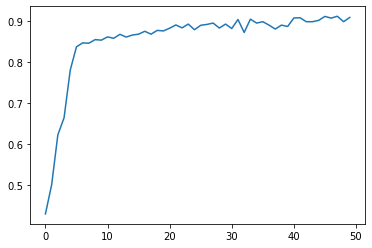

In [34]:
plot(training_acc)

#  Set 2

In [35]:
center_wavelengths = [2402, 2016, 1920, 2094, 2008, 1046, 470, 680, 1398, 1698, 1230, 896.]



In [36]:
bandwidths = [20,20,20,
             20,20,20,
              20,20,20,
              20,20,20
             ]

In [37]:
acc, X_predicted, X_groud_truth,Y_predicted, Y_groud_truth = pre_processing(hypercube, a_map, spectra,wavelength, center_wavelengths, bandwidths, return_predicted=False)

In [38]:
acc

0.0107177342809525

In [39]:
X_predicted.shape

(1600, 188)

In [40]:
Y_predicted.shape

(1600, 12)

# Start ML Bolck

In [41]:
X_predicted_half,X2_predicted_half,Y_predicted_half,Y2_predicted_half = train_test_split(X_predicted, Y_predicted, test_size=0.5)

In [42]:
x_train = np.vstack((X_predicted_half,X_groud_truth))

In [43]:
Y_predicted_half.shape

(800, 12)

In [44]:
Y_groud_truth.shape

(1600, 12)

In [45]:
y_train = np.vstack((Y_predicted_half,Y_groud_truth))

In [46]:
x_test = X2_predicted_half

In [47]:
y_test = Y2_predicted_half

In [48]:
x_train.shape

(2400, 188)

In [49]:
y_train.shape

(2400, 12)

In [50]:
x_test.shape

(800, 188)

In [51]:
y_test.shape

(800, 12)

In [52]:
#savetxt("../Machine_Learning_ref_data/x.txt",X)

In [53]:
#savetxt("../Machine_Learning_ref_data/y.txt",Y)

In [54]:
def get_compiled_model():
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(16, activation='relu'),
    
    tf.keras.layers.Dense(12,'softmax')
  ])

    model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
    return model

In [55]:
model = get_compiled_model()

In [56]:
history = model.fit(x_train,y_train, epochs=50)

Epoch 1/50
75/75 [==============================] - 0s 990us/step - loss: 0.7348 - accuracy: 0.4437
Epoch 2/50
75/75 [==============================] - 0s 976us/step - loss: 0.7346 - accuracy: 0.5562
Epoch 3/50
75/75 [==============================] - 0s 977us/step - loss: 0.7345 - accuracy: 0.6508
Epoch 4/50
75/75 [==============================] - 0s 1ms/step - loss: 0.7345 - accuracy: 0.6804
Epoch 5/50
75/75 [==============================] - 0s 1ms/step - loss: 0.7345 - accuracy: 0.6750
Epoch 6/50
75/75 [==============================] - 0s 1ms/step - loss: 0.7345 - accuracy: 0.6775
Epoch 7/50
75/75 [==============================] - 0s 980us/step - loss: 0.7344 - accuracy: 0.6896
Epoch 8/50
75/75 [==============================] - 0s 906us/step - loss: 0.7344 - accuracy: 0.7525
Epoch 9/50
75/75 [==============================] - 0s 1ms/step - loss: 0.7344 - accuracy: 0.8021
Epoch 10/50
75/75 [==============================] - 0s 889us/step - loss: 0.7344 - accuracy: 0.8233
Epoch 1

In [57]:
loss,acc = model.evaluate(x_test,y_test, verbose=1)

25/25 [==============================] - 0s 587us/step - loss: 0.7343 - accuracy: 0.8800


In [58]:
print(loss,acc)

0.7342776656150818 0.8799999952316284


In [59]:
#model.save('my_model_amazing_acc_0.99.h5')

In [60]:
# model=load_model("my_model_.hdf5")

In [61]:
training_loss_2 = history.history['loss']

In [62]:
training_acc_2 = history.history['accuracy']

In [63]:
x_axis = range(1,51)

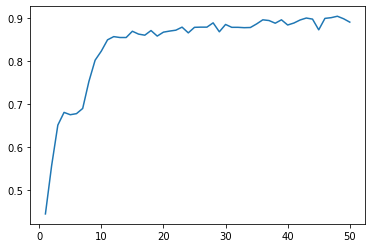

In [64]:
plot(x_axis,training_acc_2)


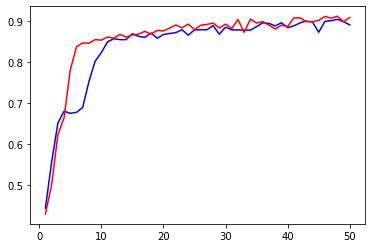

In [65]:
plot(x_axis,training_acc_2,'blue')
plot(x_axis,training_acc,'red')

Text(0.5, 1.0, 'a_map noise reduction using NN (Cuprite)')

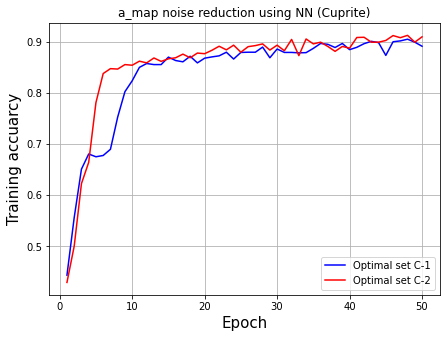

In [67]:

fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot(111)

ax.plot(x_axis,training_acc_2,'b',label = 'Optimal set C-1')
ax.plot (x_axis,training_acc,'r',label = 'Optimal set C-2')

ax.grid()
ax.legend(loc=4)

ax.set_xlabel('Epoch',fontsize=15)
ax.set_ylabel("Training accuarcy",fontsize=15)
title('a_map noise reduction using NN (Cuprite)')